In [1]:
import scipy.linalg as la
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import numpy as np
from helper_functions.grape_functions import *
from main_grape.Grape import Grape
%pylab inline



Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
qubit_num = 2


#Defining time scales
total_time = qubit_num * 3.0
steps = qubit_num * 70


state_transfer = True
#Defining H0
qubit_state_num = 2
freq_ge = 3.9#GHz
g = 2*np.pi*0.5 #GHz

ens = np.array([ 2*np.pi*ii*(freq_ge) for ii in np.arange(qubit_state_num)])
Q_x   = np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)+np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1)
Q_y   = (0+1j) *(np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)-np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1))
Q_z   = np.diag(np.arange(0,qubit_state_num))
I_q = np.identity(qubit_state_num)
H_q = np.diag(ens)

X = multi_kron(Q_x,qubit_num)
Z = multi_kron(Q_z,qubit_num)
Y = multi_kron(Q_y,qubit_num)

g_op = nn_chain_kron(Q_x, I_q, qubit_num, qubit_state_num)

#g_op_test = np.kron(np.kron(np.kron(Q_x,Q_x),I_q),I_q) + np.kron(np.kron(np.kron(I_q,Q_x),Q_x),I_q) + np.kron(np.kron(np.kron(I_q,I_q),Q_x),Q_x)
#print np.allclose(g_op, g_op_test)

H0 = kron_all(H_q,qubit_num, I_q) + g * g_op

# Defining dressed info
is_dressed = True
w_c, v_c, dressed_id = get_dressed_info(H0)
dressed_info = {'dressed_id':dressed_id, 'eigenvectors':v_c, 'eigenvalues':w_c,'is_dressed':is_dressed}


#Defining Concerned states (starting states)

psi0=[0]

all_ones_index = 0
for ii in range (qubit_num):
    all_ones_index = all_ones_index + qubit_state_num**ii
#Defining states to include in the drawing of occupation
states_draw_list = [0,all_ones_index]
states_draw_names = ['00..0','11..1']

#Defining U (Target)

if is_dressed:
    
    gg = get_state_index(0,dressed_id) #[00..0]
    ee = get_state_index(all_ones_index,dressed_id) #[11..1]
    
    target_vec = np.zeros(qubit_state_num**qubit_num,dtype=complex)
    target_vec = target_vec +  (1)/np.sqrt(2)*v_c[:,gg] + (1)/np.sqrt(2)*v_c[:,ee]
    
    U = [target_vec]

else:   
    target_vec = np.zeros(qubit_state_num**qubit_num,dtype=complex)
    target_vec[0]=(1)/np.sqrt(2)
    target_vec[all_ones_index]=1/np.sqrt(2)

    U = [target_vec]

#Defining U0 (Initial)
q_identity = np.identity(qubit_state_num**qubit_num)
U0= q_identity

#Defining control Hs

Hops = []
Hnames = []
ops_max_amp = []
Hops,Hnames,ops_max_amp = append_separate_krons(Q_x,'x',qubit_num,qubit_state_num,Hops,Hnames,ops_max_amp,amp=3.0)
Hops,Hnames,ops_max_amp = append_separate_krons(Q_z,'z',qubit_num,qubit_state_num,Hops,Hnames,ops_max_amp,amp=3.0)

print Hnames

#Defining convergence parameters
max_iterations = 5000
decay = 1000 #max_iterations/2
convergence = {'rate':0.10, 'update_step':100,'evol_save_step':1000 ,'max_iterations':max_iterations,\
               'conv_target':1e-3,'learning_rate_decay':decay,'min_grad':1e-60}

#reg_coeffs = {'envelope':0.001,'dwdt':0.0001,'d2wdt2':0.0001*0.0001}
reg_coeffs = {'envelope':0,'dwdt':0,'d2wdt2':0}


['xi', 'ix', 'zi', 'iz']


In [3]:
import h5py

with h5py.File('/home/nelson/Simulations/GRAPE-Data/spin_chain_ghz/00011_nk_spin_chain_ghz_N10.h5','r') as hf:
    u0 = np.array(hf.get('uks'))[-1]

#u0=(np.random.rand(len(Hnames),steps)-0.5) * 6

u0 = None

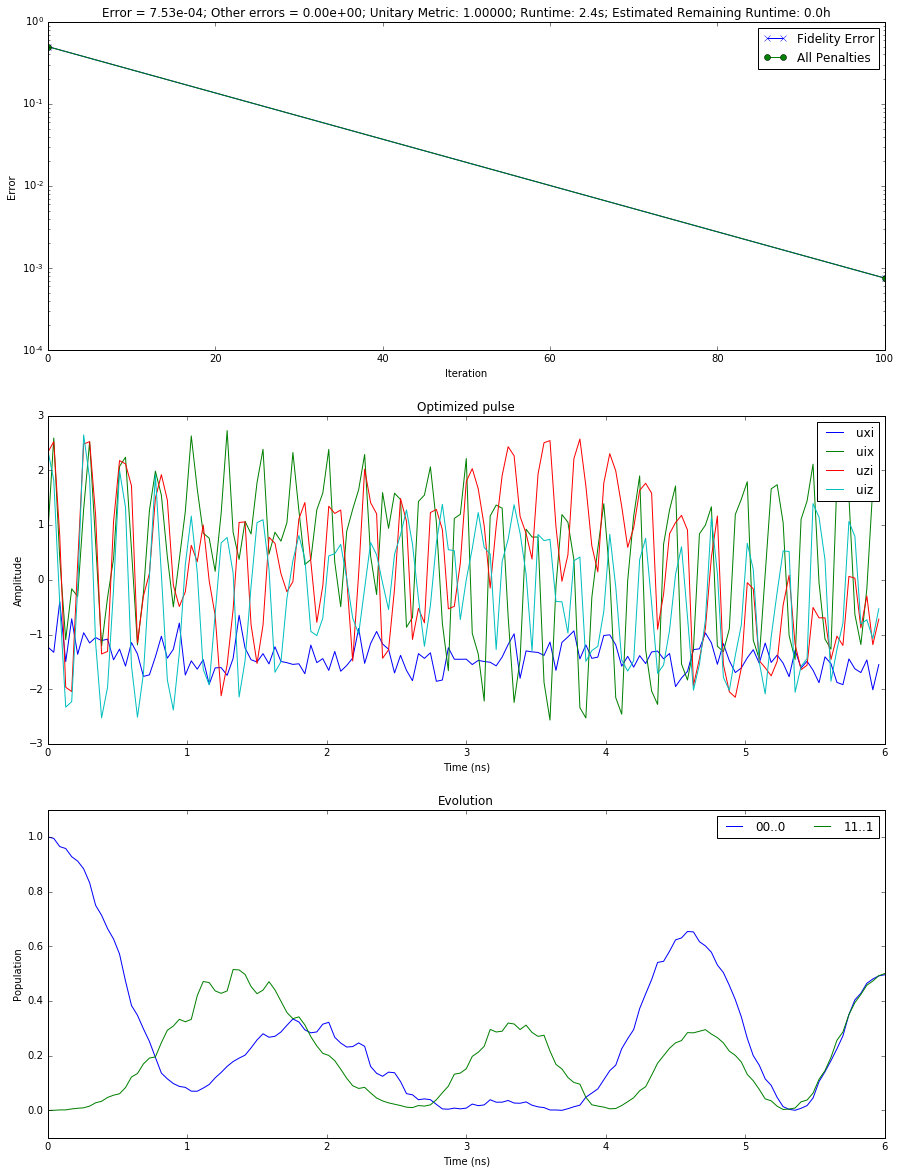

In [6]:
 #Extra options
#reg_coeffs = reg_coeffs,draw = [states_draw_list,states_draw_names] ,forbidden = states_forbidden_list,multi_mode = multi_mode,
#maxA = ops_max_amp,use_gpu = True

uks,U_final = Grape(H0,Hops,Hnames,U,total_time,steps,psi0,convergence=convergence, draw = [states_draw_list,states_draw_names],  state_transfer=True,
                    show_plots = True, use_gpu=False,
       unitary_error = 1e-6, method = 'Adam',  maxA=ops_max_amp,\
                   dressed_info = dressed_info, reg_coeffs=reg_coeffs, file_name='test004', initial_guess=u0,
                    data_path = '/home/nelson/Simulations/GRAPE-Data/spin_chain_ghz')
      
      

In [7]:
with h5py.File('/home/nelson/Simulations/GRAPE-Data/spin_chain_ghz/00000_test004.h5','r') as hf:
    print('List of arrays in this file: \n', hf.keys())
    
    conv_run_time = np.array(hf.get('run_time'))[-1]
    conv_iteration = np.array(hf.get('iteration'))[-1]
    conv_error =  np.array(hf.get('error'))[-1]
    gate_time = np.array(hf.get('total_time'))
    gate_steps = np.array(hf.get('steps'))
    wall_clock_time = np.array(hf.get('wall_clock_time'))
    
    print "conv_run_time: " + str(conv_run_time)
    print "conv_iteration: " + str(conv_iteration) 
    print "conv_error: " + str(conv_error)
    print "gate_time: " + str(gate_time)
    print "gate_steps: " + str(gate_steps)
    
    print "wall_clock_time: " + str(wall_clock_time)
    
    print "runtime/iteration: " + str(conv_run_time/conv_iteration)
    
    print np.array(hf.get('uks')).shape
    
    print np.array(hf.get('iteration'))
    
    print np.array(hf.get('inter_vecs_mag_squared')).shape


('List of arrays in this file: \n', [u'H0', u'Hnames', u'Hops', u'U', u'convergence', u'dressed_info', u'error', u'initial_vectors_c', u'inter_vecs_imag', u'inter_vecs_mag_squared', u'inter_vecs_raw_imag', u'inter_vecs_raw_real', u'inter_vecs_real', u'iteration', u'maxA', u'method', u'reg_coeffs', u'reg_error', u'run_time', u'states_concerned_list', u'steps', u'taylor_scaling', u'taylor_terms', u'total_time', u'uks', u'unitary_scale', u'wall_clock_time'])
conv_run_time: 2.43779397011
conv_iteration: 53
conv_error: 0.000752628
gate_time: 6.0
gate_steps: 140
wall_clock_time: 5.38219690323
runtime/iteration: 0.0459961126435
(7, 4, 140)
[ 0 10 20 30 40 50 53]
(7, 1, 4, 141)
